# Tick Test Signal
v2

In [23]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime

from simtools import *

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 8 )

In [2]:
# get our market data

# TODO: get the trades and quotes and merge
quote_file = '../Data/TSLA-quotes-aug19v3.zip'
trade_file = '../Data/TSLA-trades-aug19v2.zip'

#file_date = '20180117'
# load quotes and trades
quotes = loadquotefile( quote_file )
trades = loadtradefile( trade_file )

2019-10-09 18:46:04:941328: load quotes
2019-10-09 18:46:21:945837: load complete
2019-10-09 18:46:21:946645: indexing quotes
2019-10-09 18:47:07:273417: index quotes done
2019-10-09 18:47:07:442367: load trades
2019-10-09 18:47:09:133054: load complete
2019-10-09 18:47:09:133376: indexing trades
2019-10-09 18:47:15:832191: index trades done


## Spreads

In [3]:
quotes.head()

,exch,bid_px,bid_size,ask_px,ask_size,qu_cond,qu_seqnum,natbbo_ind,qu_cancel,qu_source,symbol,suffix
2019-08-01 09:30:00.221856542,A,241.34,1,243.33,1,R,943492,0,NaN,N,TSLA,NaN
2019-08-01 09:30:00.415319200,C,240.88,1,243.78,1,R,946592,0,NaN,N,TSLA,NaN
2019-08-01 09:30:00.415596052,N,241.34,1,243.33,1,R,946597,0,NaN,N,TSLA,NaN
2019-08-01 09:30:00.833394292,Y,241.46,1,243.47,3,R,953850,0,NaN,N,TSLA,NaN
2019-08-01 09:30:00.963855830,B,240.55,3,244.37,3,R,956633,0,NaN,N,TSLA,NaN


In [4]:
# calculate average spread
avg_spread = (quotes['ask_px'] - quotes['bid_px']).mean()

In [5]:
avg_spread

9.246351422971012

Is this the right calcuation?

# NO!!!!

In [6]:
# is this right?  NO!
filtered_quotes = quotes[ ( quotes.qu_source == 'N' ) & (quotes.natbbo_ind == 4 ) ]
avg_spread = (filtered_quotes.ask_px - filtered_quotes.bid_px).mean()

In [7]:
filtered_quotes = filtered_quotes[ ( filtered_quotes.ask_px != 0 ) & ( filtered_quotes.bid_px != 0 ) ]

In [8]:
len(filtered_quotes)

274660

In [9]:
avg_spread

0.12117727372025787

In [10]:
spreads = filtered_quotes['ask_px'] - filtered_quotes['bid_px']

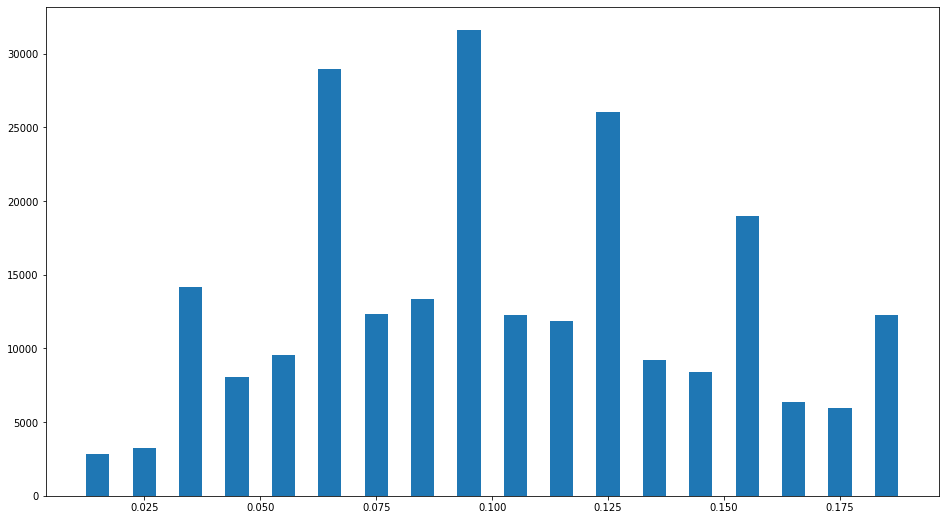

In [11]:
fig, ax1 = plt.subplots (figsize=(16,9))
ax1.hist( spreads, bins = np.arange( 0.01, 0.20, 0.01 ), rwidth = .5, log = False )
plt.show()

## Tick Test and Autocorrelation

In [12]:
trading_day = trades[ '2019-08-02' ]

In [13]:
trading_day.head()

,symbol,suffix,trade_size,trade_px
2019-08-02 09:30:00.281648858,TSLA,NaN,7,232.000
2019-08-02 09:30:00.282118475,TSLA,NaN,11,231.755
2019-08-02 09:30:00.290165337,TSLA,NaN,8,231.930
2019-08-02 09:30:00.796961420,TSLA,NaN,25,231.500
2019-08-02 09:30:00.943620182,TSLA,NaN,47328,231.350


In [14]:
# tick test to do up/down
# use shift() to calculate tick 
ticks = np.sign( trading_day.trade_px - trading_day.trade_px.shift( 1 ) )
ticks_adj = ticks.copy()

In [15]:
ticks.head(10)

2019-08-02 09:30:00.281648858    NaN
2019-08-02 09:30:00.282118475   -1.0
2019-08-02 09:30:00.290165337    1.0
2019-08-02 09:30:00.796961420   -1.0
2019-08-02 09:30:00.943620182   -1.0
2019-08-02 09:30:00.943809864    0.0
2019-08-02 09:30:00.949235110    1.0
2019-08-02 09:30:00.949246763    0.0
2019-08-02 09:30:00.949744666    0.0
2019-08-02 09:30:00.949755788   -1.0
Name: trade_px, dtype: float64

In [16]:
# better than my previous method! use replace with ffill to fill in the zero values
ticks_adj = ticks.replace(to_replace=0, method='ffill')

In [17]:
ticks_adj.head(10)

2019-08-02 09:30:00.281648858    NaN
2019-08-02 09:30:00.282118475   -1.0
2019-08-02 09:30:00.290165337    1.0
2019-08-02 09:30:00.796961420   -1.0
2019-08-02 09:30:00.943620182   -1.0
2019-08-02 09:30:00.943809864   -1.0
2019-08-02 09:30:00.949235110    1.0
2019-08-02 09:30:00.949246763    1.0
2019-08-02 09:30:00.949744666    1.0
2019-08-02 09:30:00.949755788   -1.0
Name: trade_px, dtype: float64

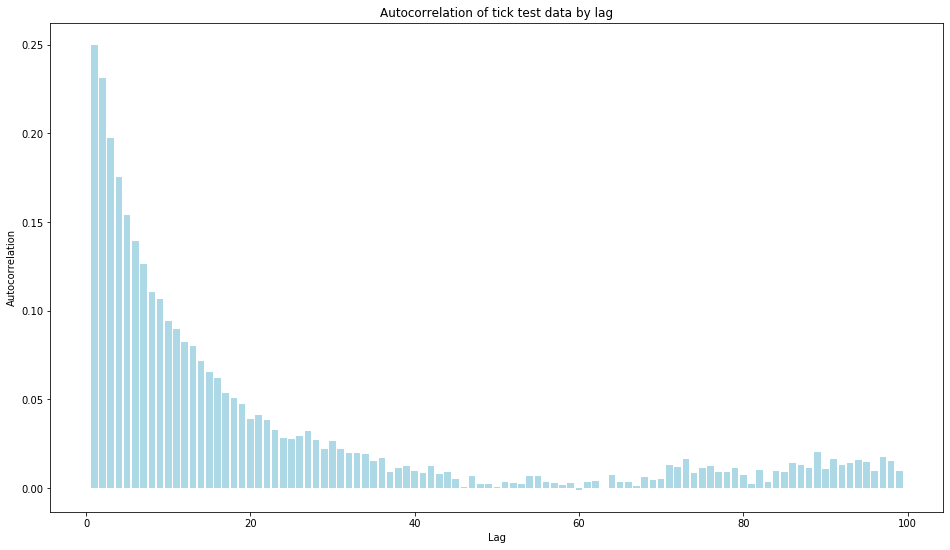

In [18]:
# Calculate autocorrelation for n lags 
fig, ax1 = plt.subplots(figsize=(16,9))
for i in np.arange( 1, 100 ):
    ax1.bar( i, ticks_adj.autocorr( lag = i ), color = 'lightblue' )
ax1.set_title( 'Autocorrelation of tick test data by lag' )
ax1.set_ylabel( 'Autocorrelation' )
ax1.set_xlabel( 'Lag' )
plt.show()

## Developing a Signal

In [20]:
# Calculate our signal: collect trades - we'll use tick count

# determine our window size
tick_window = 20

# Calc EMA directly (alpha = 2 / span +1)
ema = ticks_adj.ewm( span=tick_window ).mean()

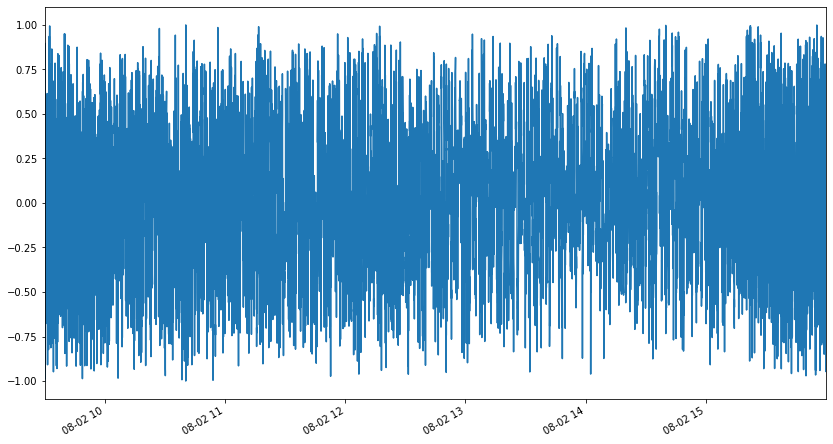

In [24]:
ema.plot()

In [25]:
ema.head()

2019-08-02 09:30:00.281648858         NaN
2019-08-02 09:30:00.282118475   -1.000000
2019-08-02 09:30:00.290165337    0.050000
2019-08-02 09:30:00.796961420   -0.335554
2019-08-02 09:30:00.943620182   -0.527369
Name: trade_px, dtype: float64

In [28]:
# to it in real time as in the simulation...
sim_ema = pd.Series( index=ticks_adj.index )

# define our accumulator for the average
accum = 0
alpha = 2 / ( tick_window + 1 )
# loop
for index, value in ticks_adj.items():
    if pd.isna( value ):
        continue
    if accum == 0:
        accum = value
    else:
        accum = ( alpha * value ) + ( 1 - alpha ) * accum
    sim_ema.loc[ index ] = accum

In [29]:
sim_ema.head(20)

2019-08-02 09:30:00.281648858         NaN
2019-08-02 09:30:00.282118475   -1.000000
2019-08-02 09:30:00.290165337   -0.809524
2019-08-02 09:30:00.796961420   -0.827664
2019-08-02 09:30:00.943620182   -0.844077
2019-08-02 09:30:00.943809864   -0.858927
2019-08-02 09:30:00.949235110   -0.681886
2019-08-02 09:30:00.949246763   -0.521707
2019-08-02 09:30:00.949744666   -0.376782
2019-08-02 09:30:00.949755788   -0.436136
2019-08-02 09:30:00.949834975   -0.489838
2019-08-02 09:30:00.949919895   -0.538425
2019-08-02 09:30:00.951962275   -0.582384
2019-08-02 09:30:00.952008045   -0.431681
2019-08-02 09:30:00.952325619   -0.485807
2019-08-02 09:30:00.952398096   -0.534777
2019-08-02 09:30:00.952619961   -0.388608
2019-08-02 09:30:00.952631477   -0.256360
2019-08-02 09:30:00.957144368   -0.327183
2019-08-02 09:30:00.957361056   -0.391260
dtype: float64

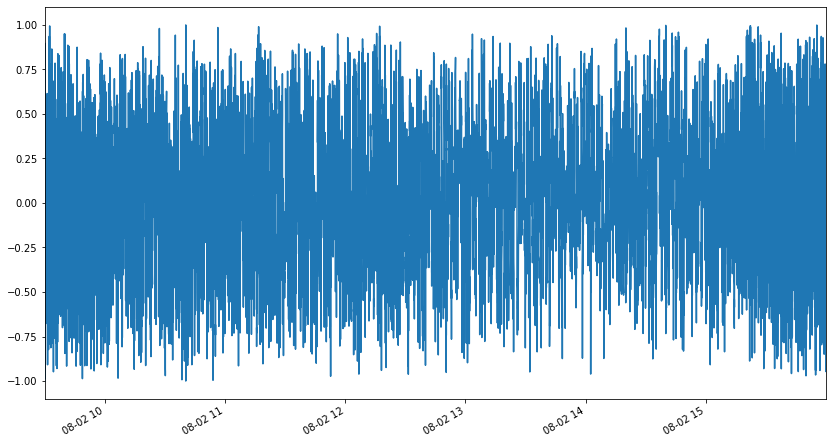

In [30]:
sim_ema.plot()
plt.show()

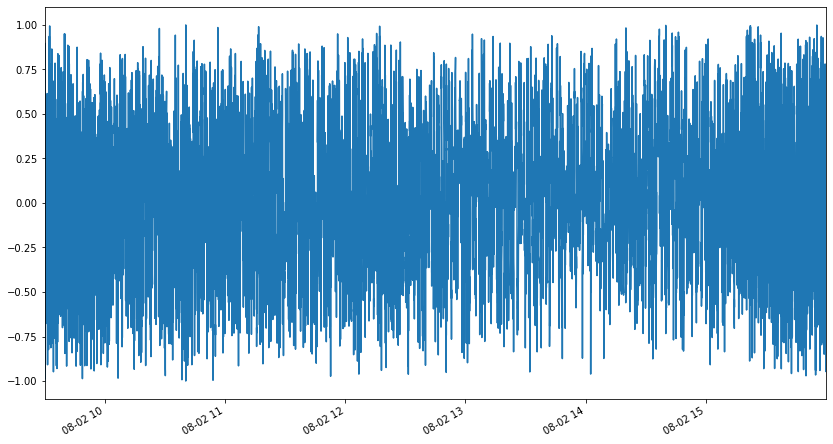

In [31]:
ema.plot()

In [33]:
sim_ema

2019-08-02 09:30:00.281648858         NaN
2019-08-02 09:30:00.282118475   -1.000000
2019-08-02 09:30:00.290165337   -0.809524
2019-08-02 09:30:00.796961420   -0.827664
2019-08-02 09:30:00.943620182   -0.844077
                                   ...   
2019-08-02 15:59:59.805041489   -0.123607
2019-08-02 15:59:59.805067898   -0.016597
2019-08-02 15:59:59.822484246    0.080222
2019-08-02 15:59:59.873036221   -0.022656
2019-08-02 15:59:59.958657374   -0.115737
Length: 65546, dtype: float64

In [34]:
values = pd.concat([sim_ema, ema], axis=1)

In [35]:
values.head(50)

,0,trade_px
2019-08-02 09:30:00.281648858,NaN,NaN
2019-08-02 09:30:00.282118475,-1.000000,-1.000000
2019-08-02 09:30:00.290165337,-0.809524,0.050000
2019-08-02 09:30:00.796961420,-0.827664,-0.335554
2019-08-02 09:30:00.943620182,-0.844077,-0.527369
2019-08-02 09:30:00.943809864,-0.858927,-0.641694
2019-08-02 09:30:00.949235110,-0.681886,-0.295372
2019-08-02 09:30:00.949246763,-0.521707,-0.050449
2019-08-02 09:30:00.949744666,-0.376782,0.131126
2019-08-02 09:30:00.949755788,-0.436136,-0.050312


In [36]:
values.columns = ['sim_ema', 'ema']

In [37]:
values.head()

,sim_ema,ema
2019-08-02 09:30:00.281648858,NaN,NaN
2019-08-02 09:30:00.282118475,-1.000000,-1.000000
2019-08-02 09:30:00.290165337,-0.809524,0.050000
2019-08-02 09:30:00.796961420,-0.827664,-0.335554
2019-08-02 09:30:00.943620182,-0.844077,-0.527369


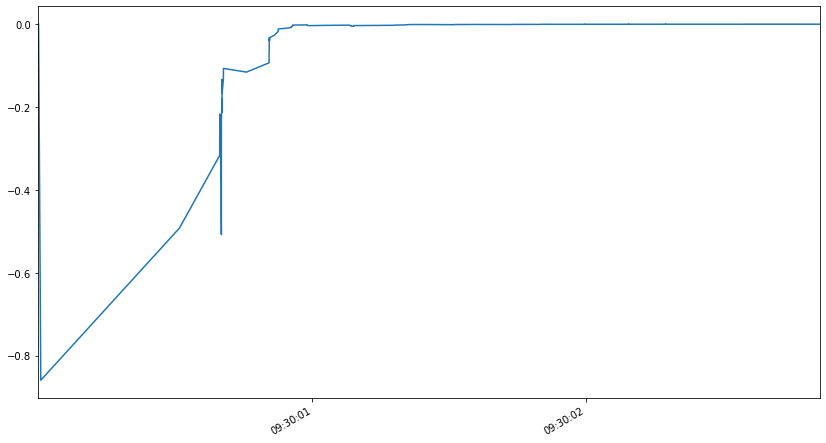

In [38]:
(values.sim_ema - values.ema).head(100).plot()